# Install Packages

In [ ]:
#https://data.jrc.ec.europa.eu/dataset/9d57494f-fd53-4ff0-8c4c-4606fc2c6d81

In [ ]:
#!pip install pandas imageio numpy rasterio geopandas cartopy matplotlib


In [ ]:
# --- System and file handling ---
import os
import pandas as pd
import imageio

# --- Numerical and array operations ---
import numpy as np

# --- Raster handling ---
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

# --- Geo-spatial handling ---
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm

# Load Data

In [ ]:
# --- Path to SPEI raster data ---
data_dir = 'spei12'

# --- Find all folders starting with 'sem01' ---
folders = [
    f for f in os.listdir(data_dir) 
    if f.startswith('spe12') and os.path.isdir(os.path.join(data_dir, f))
]

records = []

# --- Loop through folders and load all .tif files ---
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.tif'):
            file_path = os.path.join(folder_path, file)
            with rasterio.open(file_path) as src:
                img = src.read(1)  # Read the first band
                records.append({
                    'folder': folder,
                    'file': file,
                    'data': img
                })

# --- Create a DataFrame with all rasters ---
df_tiffs = pd.DataFrame(records)


In [ ]:
df_tiffs.head()

,folder,file,data
0,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990101_m_100_z01.tif,"[[-1.4169230461120605, -1.41713547706604, -1.4..."
1,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990201_m_100_z01.tif,"[[-1.2582815885543823, -1.2585994005203247, -1..."
2,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990301_m_100_z01.tif,"[[-1.1349236965179443, -1.1352102756500244, -1..."
3,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990401_m_100_z01.tif,"[[-1.0411653518676758, -1.0414129495620728, -1..."
4,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990501_m_100_z01.tif,"[[-1.2580138444900513, -1.2581218481063843, -1..."


# Plot Only Data

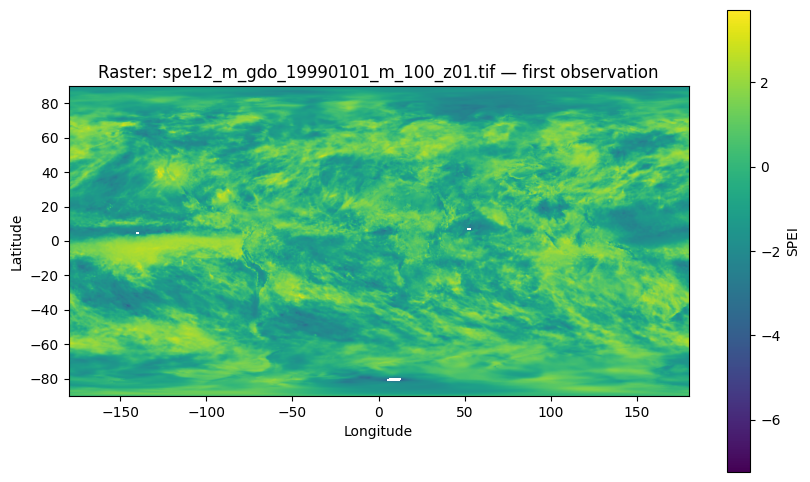

Raster geographic bounds (minx, maxx, miny, maxy): [-180.0, 180.0, -90.0, 90.0]


In [ ]:
# --- Pick the first raster observation ---
first_row = df_tiffs.iloc[0]
img = first_row['data']
folder = first_row['folder']
file = first_row['file']
file_path = os.path.join('spei12', folder, file)

# --- Reopen raster to get transform and CRS ---
with rasterio.open(file_path) as src:
    transform = src.transform
    crs = src.crs
    # Compute geographic bounds
    h, w = src.height, src.width
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
    extent = [minx, maxx, miny, maxy]

# --- Mask invalid values ---
masked = np.ma.masked_invalid(img)

# --- Plot raster ---
plt.figure(figsize=(10, 6))
plt.imshow(masked, origin='upper', extent=extent, cmap='viridis')
plt.colorbar(label='SPEI')
plt.title(f"Raster: {file} — first observation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# --- Print raster extent info ---
print("Raster geographic bounds (minx, maxx, miny, maxy):", extent)


In [ ]:
from matplotlib import colormaps  # <- new API

# --- Colormap and normalization ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy()   # replace cm.get_cmap()
cmap.set_bad(color='lightgray')      # NaNs appear gray

bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# Pick a raster file
row = df_tiffs.iloc[0]
file_path = os.path.join('spei12', row['folder'], row['file'])

# Reopen the tif to get affine transform/crs
with rasterio.open(file_path) as src:
    img = src.read(1)
    transform = src.transform
    crs = src.crs

# Mask invalid values (NaNs)
masked = np.ma.masked_invalid(img)

# Compute raster extent
h, w = img.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
extent = [minx, maxx, miny, maxy]

# Use raster CRS (EPSG:3035) for correct alignment
img_crs = ccrs.epsg(3035)

In [ ]:
# extract the 8-digit date string from the filename (e.g. '20000101')
df_tiffs['date'] = df_tiffs['file'].str.extract(r'(\d{8})', expand=False)
df_tiffs['date'] = pd.to_datetime(df_tiffs['date'], format='%Y%m%d').dt.date  # remove time component
df_tiffs.head()

,folder,file,data,date
0,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990101_m_100_z01.tif,"[[-1.4169230461120605, -1.41713547706604, -1.4...",1999-01-01
1,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990201_m_100_z01.tif,"[[-1.2582815885543823, -1.2585994005203247, -1...",1999-02-01
2,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990301_m_100_z01.tif,"[[-1.1349236965179443, -1.1352102756500244, -1...",1999-03-01
3,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990401_m_100_z01.tif,"[[-1.0411653518676758, -1.0414129495620728, -1...",1999-04-01
4,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990501_m_100_z01.tif,"[[-1.2580138444900513, -1.2581218481063843, -1...",1999-05-01


# Plot over Armenia

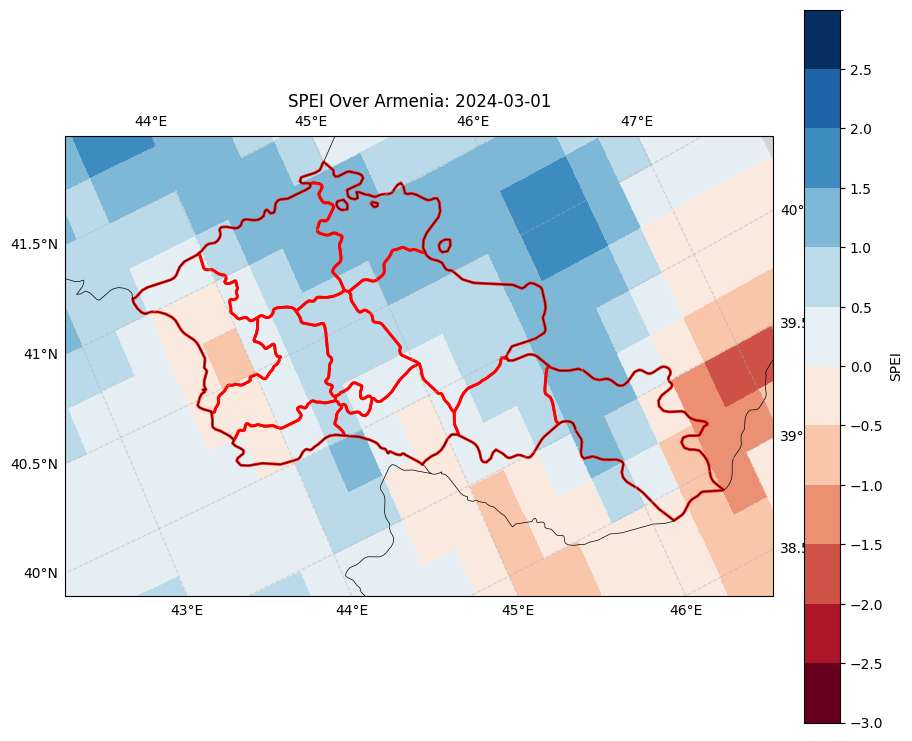

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds  # <-- added
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import colormaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Colormap setup ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].reversed().copy()
cmap.set_bad(color='lightgray')
bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# --- Pick the first raster ---
row = df_tiffs.iloc[302]
file_path = os.path.join('spei12', row['folder'], row['file'])

# --- Armenia bounding box in EPSG:3035 ---
armenia_bounds = [7000000, 7400000, 2450000, 2710000]  # minx, maxx, miny, maxy

# --- Open raster and crop to Armenia ---
with rasterio.open(file_path) as src:
    raster_bounds = src.bounds

    # Transform Armenia bbox into raster CRS (minimal change)
    arm_transformed = transform_bounds(
        'EPSG:3035',  # source CRS of armenia_bounds
        src.crs,      # destination CRS (raster CRS)
        armenia_bounds[0], armenia_bounds[2], armenia_bounds[1], armenia_bounds[3],
        densify_pts=21
    )

    # Intersect with raster bounds
    minx = max(raster_bounds.left, arm_transformed[0])
    maxx = min(raster_bounds.right, arm_transformed[2])
    miny = max(raster_bounds.bottom, arm_transformed[1])
    maxy = min(raster_bounds.top, arm_transformed[3])

    window = from_bounds(minx, miny, maxx, maxy, transform=src.transform)
    img_cropped = src.read(1, window=window)
    transform_cropped = src.window_transform(window)
    crs = src.crs

# Mask invalid values
masked_cropped = np.ma.masked_invalid(img_cropped)

# Compute correct extent for imshow
h, w = img_cropped.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform_cropped)
extent_cropped = [minx, maxx, miny, maxy]

# --- Load Armenia first-level borders ---
districts_fp = 'armenia_shapefile/am.json'
districts = gpd.read_file(districts_fp).to_crs(epsg=3035)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.epsg(3035)})

armenia_bounds_3035 = [7000000, 7400000, 2450000, 2710000]
ax.set_extent(armenia_bounds_3035, crs=ccrs.epsg(3035))

# Use raster CRS for transform in imshow
if crs.is_geographic:
    img_transform_crs = ccrs.PlateCarree()
else:
    img_transform_crs = ccrs.epsg(int(crs.to_epsg()))

im = ax.imshow(masked_cropped, origin='upper', extent=extent_cropped,
               transform=img_transform_crs, cmap=cmap, norm=norm)

# Overlay first-level borders
ax.add_geometries(districts.geometry, crs=ccrs.epsg(3035), facecolor='none', edgecolor='red', linewidth=2)

# Optional Cartopy features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label('SPEI')

ax.set_title(f"SPEI Over Armenia: {row['date']}")
plt.show()


In [ ]:
extent_cropped

[42.25076955448307, 47.75076955448307, 38.24460539601576, 41.99460539601576]

# Begin time series

In [ ]:
# Keep only January 1st observations

_dates = pd.to_datetime(df_tiffs['date'], errors='coerce')
mask = (_dates.dt.month == 1) & (_dates.dt.day == 1)

df_tiffs = df_tiffs.loc[mask].copy().reset_index(drop=True)
df_tiffs['date'] = pd.to_datetime(df_tiffs['date']).dt.date  # ensure date column is date objects

print(f"Kept {len(df_tiffs)} observations (01-01).")
df_tiffs.head()

df_tiffs['year'] = pd.to_datetime(df_tiffs['date']).dt.year
df_tiffs.head()

Kept 27 observations (01-01).


,folder,file,data,date,year
0,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990101_m_100_z01.tif,"[[-1.4169230461120605, -1.41713547706604, -1.4...",1999-01-01,1999
1,spe12_m_gdo_20000101_20001201_m,spe12_m_gdo_20000101_m_100_z01.tif,"[[-0.40673866868019104, -0.4068393111228943, -...",2000-01-01,2000
2,spe12_m_gdo_20010101_20011201_m,spe12_m_gdo_20010101_m_100_z01.tif,"[[1.0702595710754395, 1.0704095363616943, 1.07...",2001-01-01,2001
3,spe12_m_gdo_20020101_20021201_m,spe12_m_gdo_20020101_m_100_z01.tif,"[[0.1910025, 0.19088055, 0.19083989, 0.1910426...",2002-01-01,2002
4,spe12_m_gdo_20030101_20031201_m,spe12_m_gdo_20030101_m_100_z01.tif,"[[-0.9471676, -0.9470656, -0.9470682, -0.94714...",2003-01-01,2003


In [ ]:
# shift year back by 1 (e.g., 1991 -> 1990)
df_tiffs['year'] = pd.to_datetime(df_tiffs['date']).dt.year - 1

# quick check
print(df_tiffs[['date', 'year']].head())

         date  year
0  1999-01-01  1998
1  2000-01-01  1999
2  2001-01-01  2000
3  2002-01-01  2001
4  2003-01-01  2002


# Now extract per distict mean values

In [ ]:
from rasterio.features import rasterize

# For each observation compute mean SPEI for each Armenia district (pixels that are inside OR touching a district)


records = []

for _, row in df_tiffs.iterrows():
    fp = os.path.join('spei12', row['folder'], row['file'])
    with rasterio.open(fp) as src:
        arr = src.read(1).astype('float32')
        # mark nodata as nan
        if src.nodata is not None:
            arr[arr == src.nodata] = np.nan

        h, w = src.height, src.width
        transform = src.transform
        src_crs = src.crs

        # reproject districts to raster CRS
        districts_in_raster_crs = districts.to_crs(src_crs)

        # Create an integer mapping for district identifiers (original ids may be strings like 'AMTV')
        # Use a stable ordering from the GeoDataFrame
        orig_ids = districts_in_raster_crs['id'].astype(str).tolist()
        name_list = districts_in_raster_crs['name'].tolist()
        id_map = {orig_id: i + 1 for i, orig_id in enumerate(orig_ids)}       # map original id -> integer
        name_map = {i + 1: name for i, name in enumerate(name_list)}         # map integer -> name

        # prepare shapes as (geometry, integer_district_id)
        shapes = ((geom, id_map[str(did)]) for did, geom in zip(districts_in_raster_crs['id'], districts_in_raster_crs.geometry))

        # rasterize districts: all_touched=True includes pixels touching the polygon boundary
        rasterized = rasterize(
            shapes=shapes,
            out_shape=(h, w),
            transform=transform,
            fill=0,
            all_touched=True,
            dtype='int32'
        )

        # compute mean per district
        unique_ids = np.unique(rasterized)
        unique_ids = unique_ids[unique_ids != 0]  # drop background

        for did in unique_ids:
            mask = rasterized == int(did)
            if not mask.any():
                mean_val = np.nan
            else:
                mean_val = np.nanmean(arr[mask])
            # find district name using the integer->name map
            name = name_map.get(int(did), None)
            records.append({
                'date': row.get('date'),
                'year': row.get('year'),
                'folder': row['folder'],
                'file': row['file'],
                'district_id': int(did),
                'district_name': name,
                'mean_spei': float(mean_val) if not np.isnan(mean_val) else np.nan
            })

# Results: long format (one row per observation x district)
df_district_means = pd.DataFrame(records)

# Optional: wide pivot (dates x districts)
df_district_means_wide = df_district_means.pivot_table(
    index='date',
    columns='district_name',
    values='mean_spei'
)

# show a snippet
print(df_district_means.head())

         date  year                           folder  \
0  1999-01-01  1998  spe12_m_gdo_19990101_19991201_m   
1  1999-01-01  1998  spe12_m_gdo_19990101_19991201_m   
2  1999-01-01  1998  spe12_m_gdo_19990101_19991201_m   
3  1999-01-01  1998  spe12_m_gdo_19990101_19991201_m   
4  1999-01-01  1998  spe12_m_gdo_19990101_19991201_m   

                                 file  district_id district_name  mean_spei  
0  spe12_m_gdo_19990101_m_100_z01.tif            1        Tavush  -1.765876  
1  spe12_m_gdo_19990101_m_100_z01.tif            2          Lori  -1.431483  
2  spe12_m_gdo_19990101_m_100_z01.tif            3        Shirak  -1.087276  
3  spe12_m_gdo_19990101_m_100_z01.tif            4   Gegharkunik  -1.571954  
4  spe12_m_gdo_19990101_m_100_z01.tif            5   Vayots Dzor  -1.561510  


In [ ]:
# Preview existing district names so you can build the mapping
print("Before rename:", sorted(df_district_means['district_name'].unique()))

# Define the rename mapping: replace keys with desired new names
rename_map = {
    # example mappings — replace these with the actual names you want to change
    'Lori': 'Lor', #still change
    'Erevan': 'Yerevan',
    'Vayots Dzor': 'Vayots dzor',
    # add more mappings as needed
}

# Apply renaming
df_district_means['district_name'] = df_district_means['district_name'].replace(rename_map)

# Rebuild the wide pivot (if you need the wide table updated)
df_district_means_wide = df_district_means.pivot_table(
    index='date',
    columns='district_name',
    values='mean_spei'
)

# Confirm results
print("After rename:", sorted(df_district_means['district_name'].unique()))

Before rename: ['Aragatsotn', 'Ararat', 'Armavir', 'Erevan', 'Gegharkunik', 'Kotayk', 'Lori', 'Shirak', 'Syunik', 'Tavush', 'Vayots Dzor']
After rename: ['Aragatsotn', 'Ararat', 'Armavir', 'Gegharkunik', 'Kotayk', 'Lor', 'Shirak', 'Syunik', 'Tavush', 'Vayots dzor', 'Yerevan']


In [ ]:

df_district_means.to_csv('drought_data_output/armenia_yearly_spei_mean.csv', index=False)
df_district_analysis = df_district_means.copy()
df_district_analysis

,date,year,folder,file,district_id,district_name,mean_spei
0,1999-01-01,1998,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990101_m_100_z01.tif,1,Tavush,-1.765876
1,1999-01-01,1998,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990101_m_100_z01.tif,2,Lor,-1.431483
2,1999-01-01,1998,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990101_m_100_z01.tif,3,Shirak,-1.087276
3,1999-01-01,1998,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990101_m_100_z01.tif,4,Gegharkunik,-1.571954
4,1999-01-01,1998,spe12_m_gdo_19990101_19991201_m,spe12_m_gdo_19990101_m_100_z01.tif,5,Vayots dzor,-1.561510
...,...,...,...,...,...,...,...
292,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,7,Ararat,-0.491594
293,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,8,Aragatsotn,-0.038781
294,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,9,Armavir,-0.376486
295,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,10,Kotayk,0.226452


In [ ]:
# Drop observations for year 2003 and earlier
df_district_analysis = df_district_analysis[df_district_analysis['year'] > 2003].reset_index(drop=True)
df_district_analysis

,date,year,folder,file,district_id,district_name,mean_spei
0,2005-01-01,2004,spe12_m_gdo_20050101_20051201_m,spe12_m_gdo_20050101_m_100_z01.tif,1,Tavush,-0.370703
1,2005-01-01,2004,spe12_m_gdo_20050101_20051201_m,spe12_m_gdo_20050101_m_100_z01.tif,2,Lor,-0.317936
2,2005-01-01,2004,spe12_m_gdo_20050101_20051201_m,spe12_m_gdo_20050101_m_100_z01.tif,3,Shirak,-0.004208
3,2005-01-01,2004,spe12_m_gdo_20050101_20051201_m,spe12_m_gdo_20050101_m_100_z01.tif,4,Gegharkunik,0.300920
4,2005-01-01,2004,spe12_m_gdo_20050101_20051201_m,spe12_m_gdo_20050101_m_100_z01.tif,5,Vayots dzor,0.181384
...,...,...,...,...,...,...,...
226,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,7,Ararat,-0.491594
227,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,8,Aragatsotn,-0.038781
228,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,9,Armavir,-0.376486
229,2025-01-01,2024,spe12_m_gdo_20250101_20250901_m,spe12_m_gdo_20250101_m_100_z01.tif,10,Kotayk,0.226452


# Generate flags

In [ ]:
# Flag the lowest mean_spei per district (1 = lowest, 0 = otherwise)
group_min = df_district_analysis.groupby('district_name')['mean_spei'].transform('min')
df_district_analysis['yearly_flag'] = ((~df_district_analysis['mean_spei'].isna()) &
                                   np.isclose(df_district_analysis['mean_spei'], group_min)).astype(int)

# Wide form (dates x districts) of flags
df_district_analysis = df_district_analysis.pivot_table(index='district_name',
                                                  columns='year',
                                                  values='yearly_flag',
                                                  fill_value=0)

# Quick sanity check
df_district_analysis

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
district_name,,,,,,,,,,,,,,,,,,,,,
Aragatsotn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Ararat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Armavir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Gegharkunik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Kotayk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Lor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Shirak,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Syunik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Tavush,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#forward fill dummy
# forward-fill flags across years: once a district has a flag=1 it stays 1 for all subsequent years
df_district_analysis = df_district_analysis.cummax(axis=1).astype(int)
df_district_analysis

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
district_name,,,,,,,,,,,,,,,,,,,,,
Aragatsotn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Ararat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Armavir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
Gegharkunik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Kotayk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Lor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Shirak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Syunik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
Tavush,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1


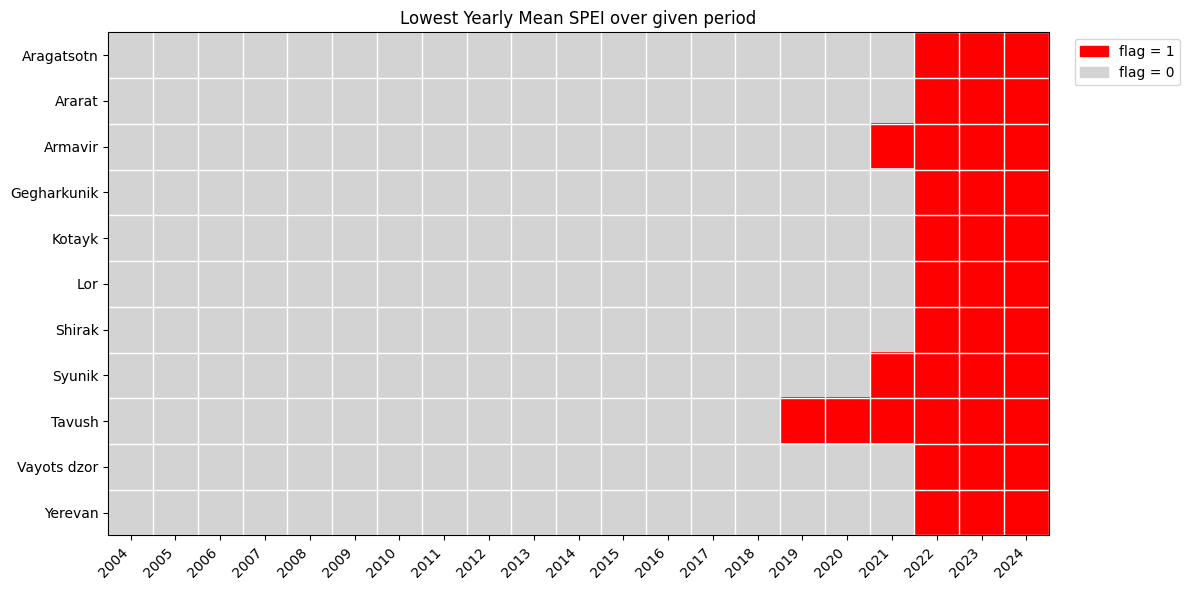

In [ ]:
# Plot districts (y) vs years (x); red where flag == 1
cols = sorted(df_district_analysis.columns)
df_plot = df_district_analysis[cols]
data = df_plot.values.astype(int)

fig, ax = plt.subplots(figsize=(12, 6))
cmap = ListedColormap(['lightgray', 'red'])
ax.imshow(data, aspect='auto', cmap=cmap, vmin=0, vmax=1)

# ticks and labels
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticks(np.arange(len(df_plot.index)))
ax.set_yticklabels(df_plot.index)

# cell grid
ax.set_xticks(np.arange(-.5, len(cols), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(df_plot.index), 1), minor=True)
ax.grid(which='minor', color='white', linewidth=1)
ax.tick_params(which='minor', length=0)

ax.set_title('Lowest Yearly Mean SPEI over given period')

# legend
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color='red', label='flag = 1'),
                  mpatches.Patch(color='lightgray', label='flag = 0')]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Convert the wide flags table (districts x years) back to long format
# Assumes df_district_analysis is the wide table with index 'district_name' and columns as years
df_flags_long = df_district_analysis.reset_index().melt(
    id_vars='district_name',
    var_name='year',
    value_name='yearly_flag'
)

# Ensure correct dtypes and ordering
df_flags_long['year'] = df_flags_long['year'].astype(int)
df_flags_long['yearly_flag'] = df_flags_long['yearly_flag'].astype(int)
df_flags_long = df_flags_long.sort_values(['district_name', 'year']).reset_index(drop=True)
df_flags_long


,district_name,year,yearly_flag
0,Aragatsotn,2004,0
1,Aragatsotn,2005,0
2,Aragatsotn,2006,0
3,Aragatsotn,2007,0
4,Aragatsotn,2008,0
...,...,...,...
226,Yerevan,2020,0
227,Yerevan,2021,0
228,Yerevan,2022,1
229,Yerevan,2023,1


In [ ]:
#save as csv
df_flags_long.to_csv('drought_data_output/armenia_lowest_yearly_spei.csv', index=False)

# Treatment 2

In [ ]:
# Flag years where mean_spei < -2

df_district_analysis = df_district_means.copy()

df_district_analysis = df_district_analysis[df_district_analysis['year'] > 2003].reset_index(drop=True)


df_district_analysis['yearly_flag'] = (
    (~df_district_analysis['mean_spei'].isna()) &
    (df_district_analysis['mean_spei'] < -2)
).astype(int)

# Convert to wide form (districts x years)
df_district_analysis = df_district_analysis.pivot_table(
    index='district_name',
    columns='year',
    values='yearly_flag',
    fill_value=0
)

df_district_analysis = df_district_analysis.cummax(axis=1).astype(int)
df_district_analysis


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
district_name,,,,,,,,,,,,,,,,,,,,,
Aragatsotn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ararat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
Armavir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gegharkunik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kotayk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Shirak,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Syunik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
Tavush,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


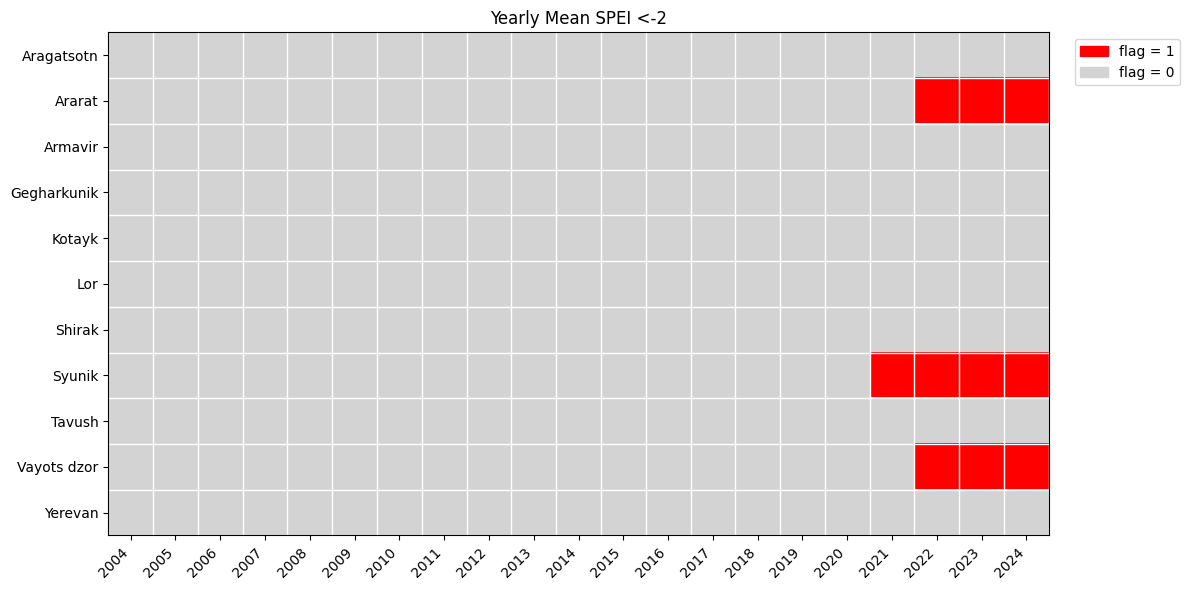

In [ ]:
# Plot districts (y) vs years (x); red where flag == 1
cols = sorted(df_district_analysis.columns)
df_plot = df_district_analysis[cols]
data = df_plot.values.astype(int)

fig, ax = plt.subplots(figsize=(12, 6))
cmap = ListedColormap(['lightgray', 'red'])
ax.imshow(data, aspect='auto', cmap=cmap, vmin=0, vmax=1)

# ticks and labels
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticks(np.arange(len(df_plot.index)))
ax.set_yticklabels(df_plot.index)

# cell grid
ax.set_xticks(np.arange(-.5, len(cols), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(df_plot.index), 1), minor=True)
ax.grid(which='minor', color='white', linewidth=1)
ax.tick_params(which='minor', length=0)

ax.set_title('Yearly Mean SPEI <-2')

# legend
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color='red', label='flag = 1'),
                  mpatches.Patch(color='lightgray', label='flag = 0')]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Convert the wide flags table (districts x years) back to long format
# Assumes df_district_analysis is the wide table with index 'district_name' and columns as years
df_flags_long = df_district_analysis.reset_index().melt(
    id_vars='district_name',
    var_name='year',
    value_name='yearly_flag'
)

# Ensure correct dtypes and ordering
df_flags_long['year'] = df_flags_long['year'].astype(int)
df_flags_long['yearly_flag'] = df_flags_long['yearly_flag'].astype(int)
df_flags_long = df_flags_long.sort_values(['district_name', 'year']).reset_index(drop=True)
df_flags_long

df_flags_long.to_csv('drought_data_output/armenia_yearly_spei_below_neg2.csv', index=False)